In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['figure.figsize'] = (12, 7)

from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose

# Load and check the data

In [2]:
train= pd.read_csv('data/demand-forecasting-kernels-only/train.csv')
test= pd.read_csv('data/demand-forecasting-kernels-only/test.csv')

In [3]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
train.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [5]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [6]:
test.tail()

,id,date,store,item
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50
44999,44999,2018-03-31,10,50


In [7]:
train.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [8]:
test.isna().sum()

id       0
date     0
store    0
item     0
dtype: int64

In [9]:
all_data = pd.concat([train, test.iloc[:, 1:]])

In [10]:
all_data.describe().round(3)

,store,item,sales
count,958000.000,958000.000,913000.000
mean,5.500,25.500,52.250
std,2.872,14.431,28.801
min,1.000,1.000,0.000
25%,3.000,13.000,30.000
50%,5.500,25.500,47.000
75%,8.000,38.000,70.000
max,10.000,50.000,231.000


In [11]:
train['date'] = pd.to_datetime(train['date'],)
train['item'] = train['item'].astype('category')

In [12]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [13]:
print("Number of unique store: ", train['store'].nunique())
print("Number of unique item: ", train['item'].nunique())

Number of unique store:  10
Number of unique item:  50


In [14]:
all_data = pd.concat([train, test])

In [15]:
all_data['date'] = pd.to_datetime(all_data['date'])

In [16]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    958000 non-null  datetime64[ns]
 1   store   958000 non-null  int64         
 2   item    958000 non-null  int64         
 3   sales   913000 non-null  float64       
 4   id      45000 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 43.9 MB


In [17]:
all_data.describe([0.1, 0.25, 0.5, .75, .95])

,store,item,sales,id
count,958000.000000,958000.000000,913000.000000,45000.000000
mean,5.500000,25.500000,52.250287,22499.500000
std,2.872283,14.430877,28.801144,12990.525394
min,1.000000,1.000000,0.000000,0.000000
10%,1.900000,5.900000,20.000000,4499.900000
25%,3.000000,13.000000,30.000000,11249.750000
50%,5.500000,25.500000,47.000000,22499.500000
75%,8.000000,38.000000,70.000000,33749.250000
95%,10.000000,48.000000,107.000000,42749.050000
max,10.000000,50.000000,231.000000,44999.000000


In [18]:
# distinct items in each store

all_data.groupby(['store'])['item'].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [19]:
all_data.groupby(['store', 'item'])['sales'].agg(['min', 'max', 'mean', 'sum'])

min    max       mean       sum
store item                                  
1     1      4.0   50.0  19.971522   36468.0
      2     13.0  115.0  53.148959   97050.0
      3      8.0   70.0  33.208105   60638.0
      4      4.0   43.0  19.956188   36440.0
      5      3.0   37.0  16.612815   30335.0
...          ...    ...        ...       ...
10    46    23.0  125.0  66.046550  120601.0
      47     6.0   56.0  24.755750   45204.0
      48    21.0  120.0  57.814896  105570.0
      49     6.0   69.0  33.032311   60317.0
      50    24.0  150.0  74.037240  135192.0

[500 rows x 4 columns]

# Creating features

In [20]:
# creating new columns

def create_date_features(df):
    
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['day of week'] = df['date'].dt.dayofweek
    df['is weekend'] = df['date'].dt.weekday //4
    df['is month end'] = df['date'].dt.year
    df['days in month'] = df['date'].dt.days_in_month
    df['is month start'] = df['date'].dt.is_month_start.astype(int)
    df['is month end'] = df['date'].dt.is_month_end.astype(int)
    
    return df
    

In [21]:
all_df = create_date_features(all_data)

In [22]:
all_df

,date,store,item,sales,id,year,month,quarter,day of week,is weekend,is month end,days in month,is month start
0,2013-01-01,1,1,13.0,NaN,2013,1,1,1,0,0,31,1
1,2013-01-02,1,1,11.0,NaN,2013,1,1,2,0,0,31,0
2,2013-01-03,1,1,14.0,NaN,2013,1,1,3,0,0,31,0
3,2013-01-04,1,1,13.0,NaN,2013,1,1,4,1,0,31,0
4,2013-01-05,1,1,10.0,NaN,2013,1,1,5,1,0,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,2018,3,1,1,0,0,31,0
44996,2018-03-28,10,50,NaN,44996.0,2018,3,1,2,0,0,31,0
44997,2018-03-29,10,50,NaN,44997.0,2018,3,1,3,0,0,31,0
44998,2018-03-30,10,50,NaN,44998.0,2018,3,1,4,1,0,31,0


In [23]:
all_data.drop('id', axis=1, inplace=True)

In [24]:
# extra analysis

all_df.groupby(['store', 'item', 'year', 'month'])['sales'].agg(['min', 'max', 'mean', 'sum'])

min    max       mean     sum
store item year month                                
1     1    2013 1       5.0   18.0  10.580645   328.0
                2       7.0   21.0  11.500000   322.0
                3      10.0   22.0  15.387097   477.0
                4       9.0   26.0  17.400000   522.0
                5       7.0   27.0  17.129032   531.0
...                     ...    ...        ...     ...
10    50   2017 11     62.0  123.0  85.800000  2574.0
                12     41.0   86.0  64.096774  1987.0
           2018 1       NaN    NaN        NaN     0.0
                2       NaN    NaN        NaN     0.0
                3       NaN    NaN        NaN     0.0

[31500 rows x 4 columns]

In [25]:
all_df.groupby(['store', 'item', 'year', 'quarter'])['sales'].agg(['min', 'max', 'mean', 'sum'])

min    max       mean     sum
store item year quarter                                
1     1    2013 1         5.0   22.0  12.522222  1127.0
                2         7.0   38.0  18.461538  1680.0
                3         8.0   34.0  19.282609  1774.0
                4         5.0   31.0  15.695652  1444.0
           2014 1         4.0   31.0  15.433333  1389.0
...                       ...    ...        ...     ...
10    50   2017 1        32.0   93.0  63.977778  5758.0
                2        54.0  150.0  95.274725  8670.0
                3        59.0  143.0  95.260870  8764.0
                4        41.0  123.0  76.826087  7068.0
           2018 1         NaN    NaN        NaN     0.0

[10500 rows x 4 columns]

In [26]:
# creating lag features


def create_lags(dataframe, lags, colname):
    
    
    for lag in lags:
        dataframe[colname+'-lag-'+str(lag)] = dataframe.groupby(['store', 'item'])['sales'].shift(lag)
        
    return dataframe

In [27]:
all_df = create_lags(all_df, lags= [12, 34, 50, 100, 256], colname='sales')

In [28]:
all_df

,date,store,item,sales,year,month,quarter,day of week,is weekend,is month end,days in month,is month start,sales-lag-12,sales-lag-34,sales-lag-50,sales-lag-100,sales-lag-256
0,2013-01-01,1,1,13.0,2013,1,1,1,0,0,31,1,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,2013,1,1,2,0,0,31,0,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,2013,1,1,3,0,0,31,0,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,2013,1,1,4,1,0,31,0,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,2013,1,1,5,1,0,31,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,2018,3,1,1,0,0,31,0,NaN,NaN,NaN,86.0,101.0
44996,2018-03-28,10,50,NaN,2018,3,1,2,0,0,31,0,NaN,NaN,NaN,53.0,109.0
44997,2018-03-29,10,50,NaN,2018,3,1,3,0,0,31,0,NaN,NaN,NaN,54.0,143.0
44998,2018-03-30,10,50,NaN,2018,3,1,4,1,0,31,0,NaN,NaN,NaN,51.0,72.0


In [29]:
# creating rolling mean features

def rollmean_feature(dataframe, window):
    
    for w in window:
        dataframe['sales_roll_mean_'+str(w)] = dataframe.\
        groupby(['store', 'item'])['sales'].shift(1).rolling(window= w, min_periods = 10).mean()
    return dataframe

In [30]:
all_df = rollmean_feature(all_df, window=[365, 456, 548])

In [31]:
all_df

,date,store,item,sales,year,month,quarter,day of week,is weekend,is month end,days in month,is month start,sales-lag-12,sales-lag-34,sales-lag-50,sales-lag-100,sales-lag-256,sales_roll_mean_365,sales_roll_mean_456,sales_roll_mean_548
0,2013-01-01,1,1,13.0,2013,1,1,1,0,0,31,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,2013,1,1,2,0,0,31,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,2013,1,1,3,0,0,31,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,2013,1,1,4,1,0,31,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,2013,1,1,5,1,0,31,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,2018,3,1,1,0,0,31,0,NaN,NaN,NaN,86.0,101.0,NaN,NaN,NaN
44996,2018-03-28,10,50,NaN,2018,3,1,2,0,0,31,0,NaN,NaN,NaN,53.0,109.0,NaN,NaN,NaN
44997,2018-03-29,10,50,NaN,2018,3,1,3,0,0,31,0,NaN,NaN,NaN,54.0,143.0,NaN,NaN,NaN
44998,2018-03-30,10,50,NaN,2018,3,1,4,1,0,31,0,NaN,NaN,NaN,51.0,72.0,NaN,NaN,NaN


In [32]:
# I then encode the categorical columns

all_df = pd.get_dummies(all_df, columns=['store', 'item', 'month', 'quarter', 'day of week'])

In [33]:
all_df

,date,sales,year,is weekend,is month end,days in month,is month start,sales-lag-12,sales-lag-34,sales-lag-50,...,quarter_2,quarter_3,quarter_4,day of week_0,day of week_1,day of week_2,day of week_3,day of week_4,day of week_5,day of week_6
0,2013-01-01,13.0,2013,0,0,31,1,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
1,2013-01-02,11.0,2013,0,0,31,0,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2,2013-01-03,14.0,2013,0,0,31,0,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
3,2013-01-04,13.0,2013,1,0,31,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
4,2013-01-05,10.0,2013,1,0,31,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,NaN,2018,0,0,31,0,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
44996,2018-03-28,NaN,2018,0,0,31,0,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
44997,2018-03-29,NaN,2018,0,0,31,0,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
44998,2018-03-30,NaN,2018,1,0,31,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0


In [34]:
# scale the target variable

all_df['sales'] = np.log1p(all_df['sales'].values)

In [35]:
all_df

,date,sales,year,is weekend,is month end,days in month,is month start,sales-lag-12,sales-lag-34,sales-lag-50,...,quarter_2,quarter_3,quarter_4,day of week_0,day of week_1,day of week_2,day of week_3,day of week_4,day of week_5,day of week_6
0,2013-01-01,2.639057,2013,0,0,31,1,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
1,2013-01-02,2.484907,2013,0,0,31,0,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2,2013-01-03,2.708050,2013,0,0,31,0,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
3,2013-01-04,2.639057,2013,1,0,31,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
4,2013-01-05,2.397895,2013,1,0,31,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,NaN,2018,0,0,31,0,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
44996,2018-03-28,NaN,2018,0,0,31,0,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
44997,2018-03-29,NaN,2018,0,0,31,0,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
44998,2018-03-30,NaN,2018,1,0,31,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0


# data splitting and model fitting

In [36]:
# now we create train and test set
# and fit the data to our model..

In [37]:
all_df.set_index('date', inplace=True)

In [38]:
train_set = all_df.loc['2013-01-01': '2017-12-31']
test_set= all_df.loc['2018-01-01': '2018-03-31']

In [39]:
train_target = train_set['sales']
test_target= test_set['sales']

In [40]:
train_set.columns

Index(['sales', 'year', 'is weekend', 'is month end', 'days in month',
       'is month start', 'sales-lag-12', 'sales-lag-34', 'sales-lag-50',
       'sales-lag-100', 'sales-lag-256', 'sales_roll_mean_365',
       'sales_roll_mean_456', 'sales_roll_mean_548', 'store_1', 'store_2',
       'store_3', 'store_4', 'store_5', 'store_6', 'store_7', 'store_8',
       'store_9', 'store_10', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5',
       'item_6', 'item_7', 'item_8', 'item_9', 'item_10', 'item_11', 'item_12',
       'item_13', 'item_14', 'item_15', 'item_16', 'item_17', 'item_18',
       'item_19', 'item_20', 'item_21', 'item_22', 'item_23', 'item_24',
       'item_25', 'item_26', 'item_27', 'item_28', 'item_29', 'item_30',
       'item_31', 'item_32', 'item_33', 'item_34', 'item_35', 'item_36',
       'item_37', 'item_38', 'item_39', 'item_40', 'item_41', 'item_42',
       'item_43', 'item_44', 'item_45', 'item_46', 'item_47', 'item_48',
       'item_49', 'item_50', 'month_1', 'month

In [41]:
X_col = ['is weekend', 'is month end', 'days in month',
       'is month start', 'sales-lag-12', 'sales-lag-34', 'sales-lag-50',
       'sales-lag-100', 'sales-lag-256', 'sales_roll_mean_365',
       'sales_roll_mean_456', 'sales_roll_mean_548', 'store_1', 'store_2',
       'store_3', 'store_4', 'store_5', 'store_6', 'store_7', 'store_8',
       'store_9', 'store_10', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5',
       'item_6', 'item_7', 'item_8', 'item_9', 'item_10', 'item_11', 'item_12',
       'item_13', 'item_14', 'item_15', 'item_16', 'item_17', 'item_18',
       'item_19', 'item_20', 'item_21', 'item_22', 'item_23', 'item_24',
       'item_25', 'item_26', 'item_27', 'item_28', 'item_29', 'item_30',
       'item_31', 'item_32', 'item_33', 'item_34', 'item_35', 'item_36',
       'item_37', 'item_38', 'item_39', 'item_40', 'item_41', 'item_42',
       'item_43', 'item_44', 'item_45', 'item_46', 'item_47', 'item_48',
       'item_49', 'item_50', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'quarter_1', 'quarter_2', 'quarter_3',
       'quarter_4', 'day of week_0', 'day of week_1', 'day of week_2',
       'day of week_3', 'day of week_4', 'day of week_5', 'day of week_6']

y_col= ['sales']

In [42]:
X_train = train_set[X_col]
X_test =test_set[X_col]

y_train = train_set[y_col]
y_test = test_set[y_col]

In [43]:
X_test

,is weekend,is month end,days in month,is month start,sales-lag-12,sales-lag-34,sales-lag-50,sales-lag-100,sales-lag-256,sales_roll_mean_365,...,quarter_2,quarter_3,quarter_4,day of week_0,day of week_1,day of week_2,day of week_3,day of week_4,day of week_5,day of week_6
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0,0,31,1,16.0,14.0,27.0,37.0,26.0,82.742466,...,0,0,0,1,0,0,0,0,0,0
2018-01-02,0,0,31,0,12.0,28.0,22.0,24.0,27.0,82.780220,...,0,0,0,0,1,0,0,0,0,0
2018-01-03,0,0,31,0,6.0,15.0,16.0,14.0,19.0,82.898072,...,0,0,0,0,0,1,0,0,0,0
2018-01-04,0,0,31,0,18.0,19.0,19.0,18.0,22.0,82.953039,...,0,0,0,0,0,0,1,0,0,0
2018-01-05,1,0,31,0,19.0,16.0,22.0,27.0,17.0,83.008310,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-27,0,0,31,0,NaN,NaN,NaN,86.0,101.0,NaN,...,0,0,0,0,1,0,0,0,0,0
2018-03-28,0,0,31,0,NaN,NaN,NaN,53.0,109.0,NaN,...,0,0,0,0,0,1,0,0,0,0
2018-03-29,0,0,31,0,NaN,NaN,NaN,54.0,143.0,NaN,...,0,0,0,0,0,0,1,0,0,0


In [44]:
import lightgbm as lgb

In [45]:

l_train = lgb.Dataset(data=X_train, label=y_train, feature_name=X_col)
l_test = lgb.Dataset(data=X_test, label=y_test, reference=l_train, feature_name=X_col)

params = {'metric':'mae', 'num_leaves':12, 'learning_rate':0.01}
model = lgb.train(params=params,train_set=l_train, valid_sets=[l_train, l_test], )


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1889
[LightGBM] [Info] Number of data points in the train set: 913000, number of used features: 95
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3.820443
[1]	training's l1: 0.468505	valid_1's l1: 3.81135
[2]	training's l1: 0.464651	valid_1's l1: 3.80236
[3]	training's l1: 0.460845	valid_1's l1: 3.79346
[4]	training's l1: 0.457078	valid_1's l1: 3.78465
[5]	training's l1: 0.453354	valid_1's l1: 3.7758
[6]	training's l1: 0.449678	valid_1's l1: 3.76715
[7]	training's l1: 0.446056	valid_1's l1: 3.75861
[8]	training's l1: 0.442491	valid_1's l1: 3.75065
[9]	training's l1: 0.438952	val

In [48]:
F = model.predict(X_test, num_iteration=model.best_iteration)

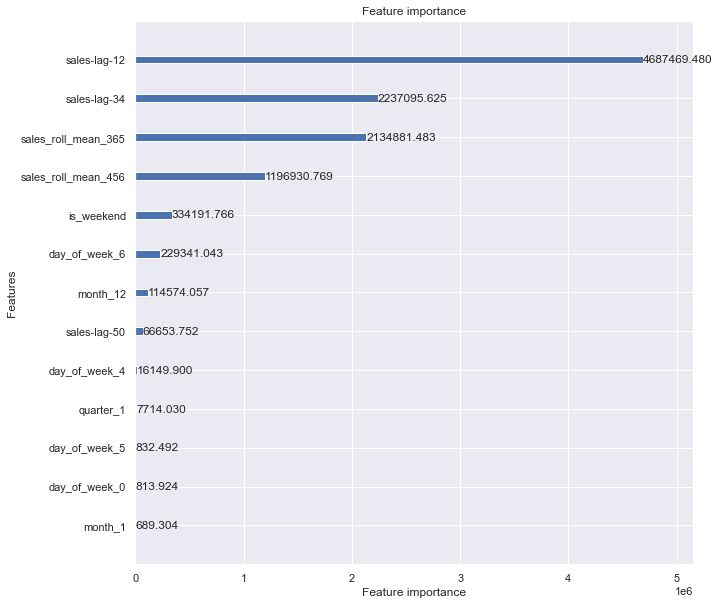

In [47]:
lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(10, 10))
plt.show()

In [51]:
sample = all_data[['date', 'store', 'item', 'sales']]

In [52]:
sample.isna().sum()

date         0
store        0
item         0
sales    45000
dtype: int64

In [53]:
len(F)

45000

<AxesSubplot:title={'center':'Forecast for next (12) months'}, xlabel='date'>

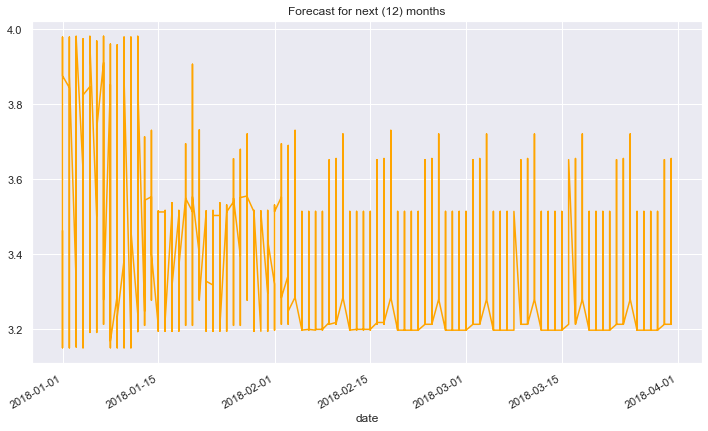

In [64]:
pd.Series(F, index= X_test.index).plot(color= 'orange', title='Forecast for next (12) months')

<AxesSubplot:xlabel='date'>

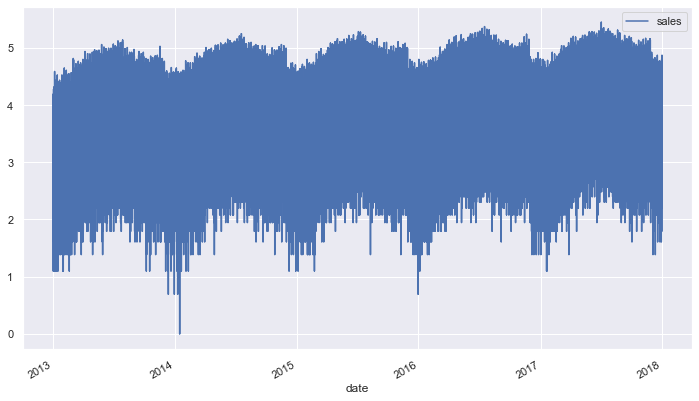

In [62]:
y_train.plot()

In [63]:
all_df.sales.describe()

count    913000.000000
mean          3.820443
std           0.578715
min           0.000000
25%           3.433987
50%           3.871201
75%           4.262680
max           5.446737
Name: sales, dtype: float64